# AMSC698K Homework 4
##### Elijah Kin & Noorain Noorani

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import numpy as np


print(qiskit.__version__)

1.2.4


## General Grover's Algorithm Code

In [2]:
# Diffusion (sandwiched reflection) operator
def diffuser(q, label='diffuser'):    
    qc = QuantumCircuit(q)         
    n = qc.num_qubits   
    qc.h([q[i] for i in range(n-1)])
    qc.x([ q[i] for i in range(n-1) ])         
    if n > 2:
        # for multi-controlled Z use multi-controlled Z rotation
        qc.mcrz(np.pi, q[0:n-2], q[n-2])
    else:
        # for one-qubit oracles no controls
        qc.z(q[0])
    qc.barrier()
    qc.x([ q[i] for i in range(n-1) ])
    qc.h([ q[i] for i in range(n-1) ])    
    return qc

In [15]:
def grover(nqubits, oracle, iterations=1, measure=True):
    
    q = QuantumRegister(nqubits, name='q') # create the quantum register
    if(measure):
    # measure only qubits that are input to the oracle
        creg = ClassicalRegister(nqubits-1, name='c') 
        qc = QuantumCircuit(q,creg)         # create the circuit
    else:
        qc = QuantumCircuit(q)           # circuit without measurements

    # initialize the circuit:
    # the qubit that receives the oracle output must be set to |1>
    qc.x(nqubits-1) 
    qc.h([ q[i] for i in range(nqubits) ])  
    qc.save_statevector(label='init')    
    
    # add repetitions of oracle plus diffusion operator
    for i in range(iterations):  
        qc.compose(oracle(q), q, inplace=True)
        qc.barrier()
        qc.compose(diffuser(q), q, inplace=True)
        qc.save_statevector(label=f"diffuser_{i}")

    if(measure):  # Measurements
        qc.measure(q[0:nqubits-1],creg)        
    return qc

### 1. Use Grover's algorithm (or Amplitude Amplification (QAA)) to solve these problems:

A. Alice, Bob, Charlie, Dora want to set up a meeting. Alice can only meet on Monday, Tuesday, or Thursday; Bob cannot meet on Wednesday; Charlie cannot meet on Thursday, Dora cannot meet on Tuesday nor Friday. Find the day they can meet using Grover's algorithm.

In [ ]:
# Oracle for the Scheduling problem

def Scheduling_Oracle(q):
    # use a multicontrolled X gate 
    circ = QuantumCircuit(q)
    # TODO
    # circ.mcx(q[0:-1], q[-1], mode='noancilla')    
    return circ

# We can construct the oracle using the constraints given in the question
# How would I implement???

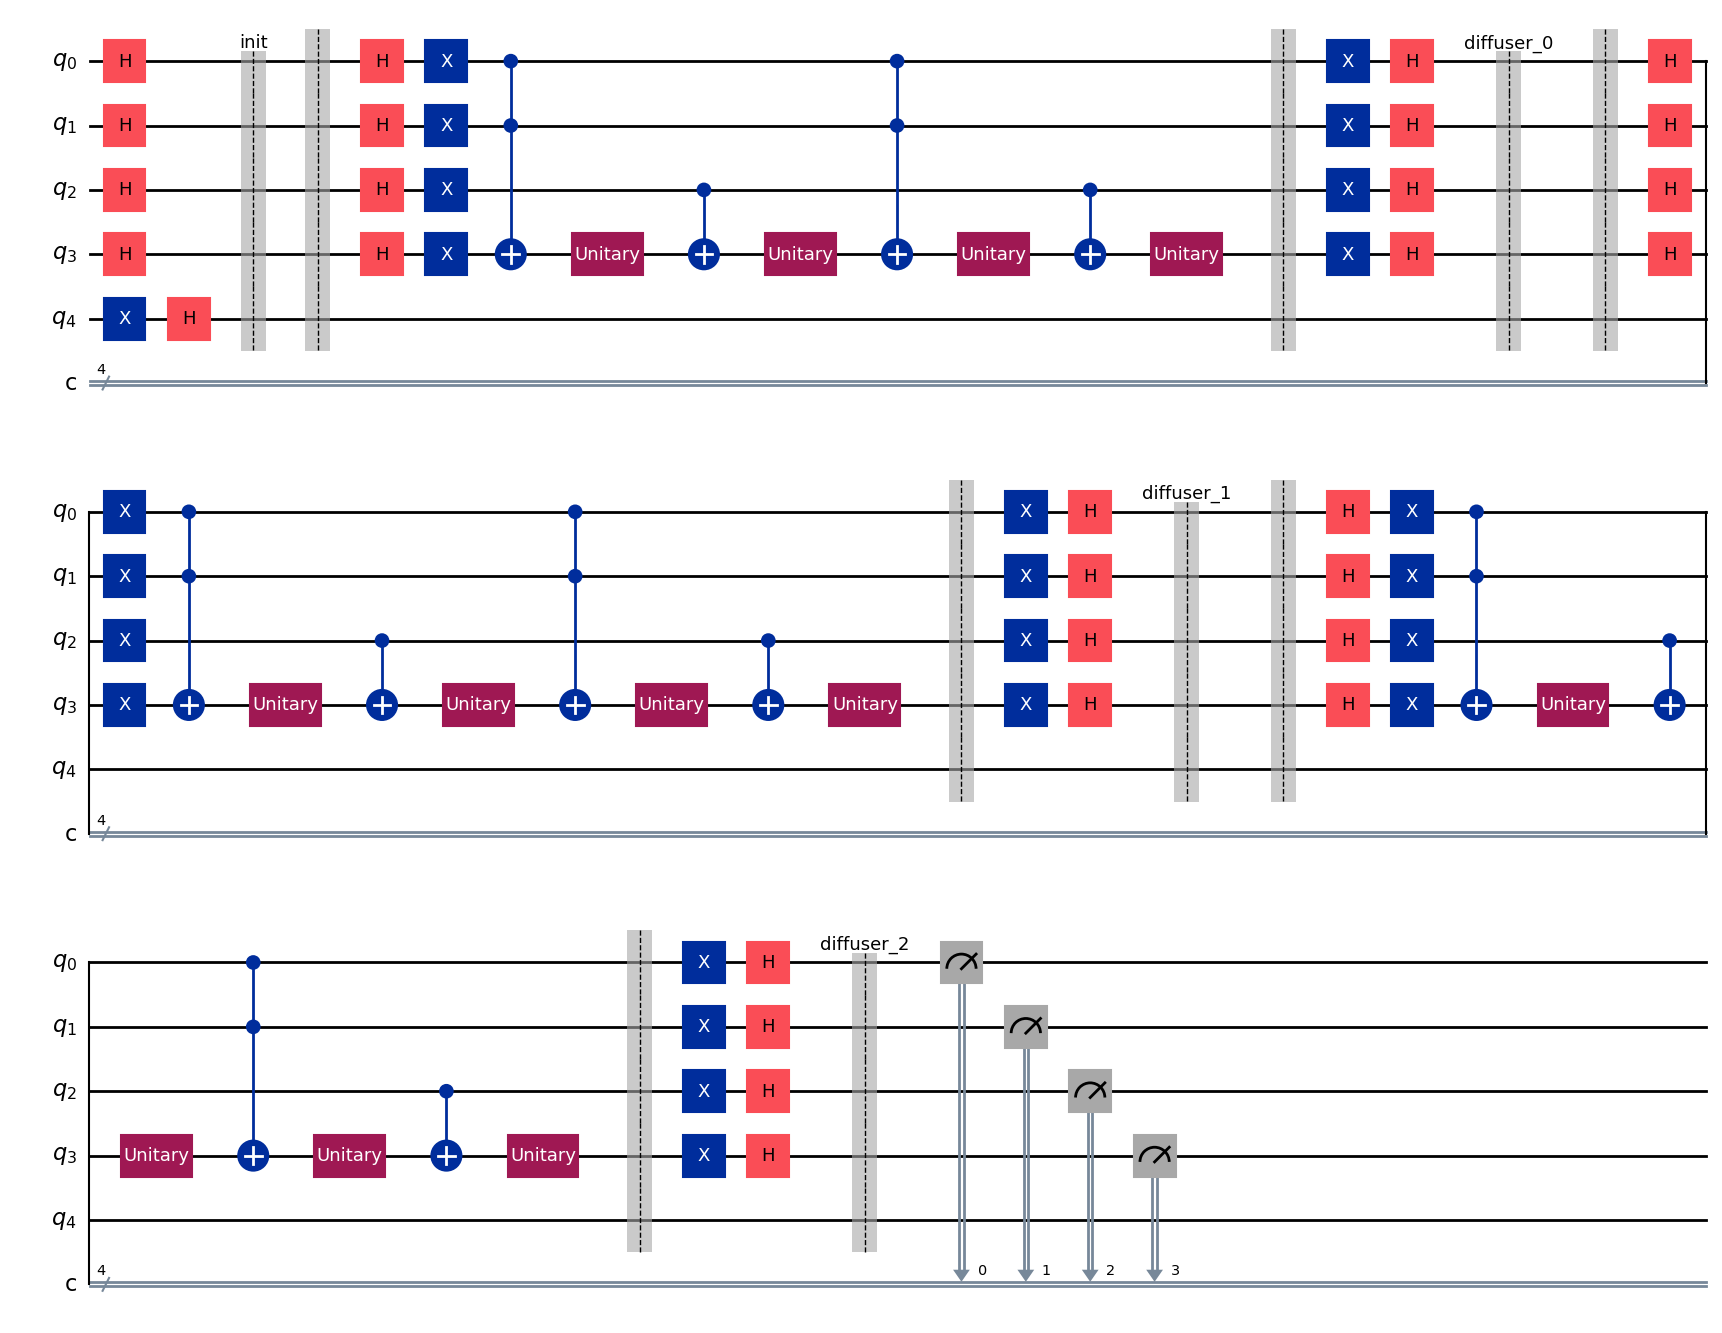

In [16]:
nqubits = 5

circ_grover1 = grover(nqubits, Scheduling_Oracle, iterations = 3)
circ_grover1.draw(output = 'mpl', plot_barriers=True)

B. Alice and Bob work at the front desk of their company from Monday to Wednesday in 2 shifts; each shift is assigned to one employee. Write the constraints as logic expressions and use Grover's algorithm to see whether the shifts can be assigned to Alice and Bob (i) if Alice doesn't want to work more than 4 shifts at the front desk and Bob doesn't want to work on consecutive days at the front desk; (ii) Bob doesn't want to have the same shift on consecutive days and Alice prefers afternoon shifts; what if Alice doesn't want any morning shift?

In [3]:
# TODO

C. Consider a set of 24 marbles, some marbles are white colored and the rest black. Apply QAA to identify the white-colored marbles if 2, 3, 4, or 14 marbles are white-colored. How many sequences of QAA do you have to apply to find the marbles at less than 5% uncertainty.

In [4]:
# TODO

### 2. Given the unsorted list [7,62,48,55,39,17,32,15,27,0,41,3,59,31,51,4].
Use Grover's algorithm (or QAA) to find the list indices of numbers 32, 3, and 27.

In [ ]:
# TODO
# 16 states, 4 qubits
# Want to find 32, 3, and 27.
# Looking for the list indicides
N = 4